In [1]:
import torch
from torch import nn

from tqdm import tqdm
from torchinfo import summary
import pytorch_lightning as pl

import utils.data as data

In [2]:
class ConvLayer(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=(3, 3),
        stride=1,
        padding=1,
        *args,
        **kwargs,
    ):

        super(ConvLayer, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, *args, **kwargs
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels, out_channels, kernel_size, 1, padding, *args, **kwargs
            ),
            nn.ReLU(),
        )

        if stride == 2:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, (1, 1), stride=2),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.block(x)

        if out.shape == x.shape:
            return torch.relu(out + x)

        dwn = self.down(x)

        return torch.relu(out + dwn)

In [3]:
class ResNet32(pl.LightningModule):
    def __init__(self, in_channels, num_classes):
        super(ResNet32, self).__init__()

        self.top = nn.Sequential(
            nn.Conv2d(in_channels, 64, (7, 7), stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), padding=1),
        )

        self.res_blocks = nn.Sequential(
            ConvLayer(64, 64),
            ConvLayer(64, 64),
            ConvLayer(64, 64),
            # 64 -> 128
            ConvLayer(64, 128, stride=2),
            ConvLayer(128, 128),
            ConvLayer(128, 128),
            # 128 -> 256
            ConvLayer(128, 256, stride=2),
            ConvLayer(256, 256),
            ConvLayer(256, 256),
            ConvLayer(256, 256),
            ConvLayer(256, 256),
            ConvLayer(256, 256),
            # 256 -> 512
            ConvLayer(256, 512, stride=2),
            ConvLayer(512, 512),
            ConvLayer(512, 512),
        )

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes),
        )

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.top(x)

        x = self.res_blocks(x)

        return self.fc(x)

    def training_step(self, xb, batch_idx):
        inp, labels = xb
        out = self(inp)

        return self.loss(out, labels)

    def validation_step(self, xb, batch_idx):
        inp, labels = xb
        out = self(inp)

        labels_hat = torch.argmax(out, dim=1)
        val_acc = torch.sum(labels == labels_hat).item() / (len(labels) * 1.0)

        self.log("val_loss", self.loss(out, labels), on_step=True)
        self.log("val_acc", val_acc, on_step=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=2e-4)

In [4]:
def train():
    num_classes = 10
    in_channels = 1
    epochs = 3
    model = ResNet32(in_channels, num_classes)
    summary(model, input_size=(1, 1, 28, 28))

    trainer = pl.Trainer(
        default_root_dir="logs",
        gpus=(1 if torch.cuda.is_available() else 0),
        max_epochs=epochs,
        logger=pl.loggers.TensorBoardLogger("logs/", name="resnet", version=0),
        precision=16,
    )

    trainer.fit(model, train_dataloader=data.train_dl, val_dataloaders=data.val_dl)

    trainer.save_checkpoint("checkpoints/resnet.ckpt", weights_only=True)

In [5]:
@torch.no_grad()
def eval():
    from utils.hooks import FeatureExtractor
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    num_classes = 10
    in_channels = 1
    # model = ResNet32(in_channels, num_classes)
    model = ResNet32.load_from_checkpoint(
        "checkpoints/resnet.ckpt", in_channels=in_channels, num_classes=num_classes
    ).eval()

    model = FeatureExtractor(model, ["fc.0"])

    ys = []
    outs = []
    for x, y in tqdm(data.val_dl):
        out = model(x).get("fc.0").detach()
        outs.append(out.reshape(x.shape[0], -1))
        ys.append(y)

    outs = torch.cat(outs, dim=0)
    ys = torch.cat(ys, dim=0)

    print(outs.shape)
    print(ys.shape)

    decomposer = PCA(n_components=3)
    decomposed = decomposer.fit_transform(outs.numpy())

    colors = {
        1: "blue",
        2: "orange",
        3: "green",
        4: "red",
        5: "purple",
        6: "brown",
        7: "pink",
        8: "gray",
        9: "olive",
        0: "cyan",
    }

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    ax.scatter(
        xs=decomposed[:, 0],
        ys=decomposed[:, 1],
        zs=decomposed[:, 2],
        c=list(map(lambda x: colors[int(x)], list(ys))),
    )
    plt.show()

In [6]:
train()

Epoch 1:  86%|████████▌ | 938/1095 [06:10<01:02,  2.53it/s, loss=0.0454, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  86%|████████▌ | 938/1095 [06:15<01:02,  2.50it/s, loss=0.0195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 1095/1095 [06:31<00:00,  2.79it/s, loss=0.0195, v_num=0]


100%|██████████| 157/157 [00:27<00:00,  5.64it/s]
torch.Size([10000, 512])
torch.Size([10000])


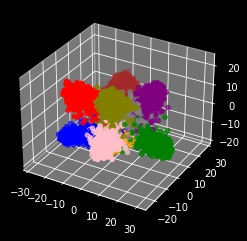

In [7]:
eval()